In [1]:
model_file = '/Users/wang04/cnn_all_FM_SC_tp1/model_n_isize_n_motif_s1_C_n_motif_s1_T_TF_0_1_.binary_model.h5'

x_file_path = '/Users/wang04/cnn_all_dbs_tp1/x_clean_n_isize_n_motif_s1_C_n_motif_s1_T_TF_0_1_.npy'
y_file_path = '/Users/wang04/cnn_all_dbs_tp1/y_clean_n_isize_n_motif_s1_C_n_motif_s1_T_TF_0_1_.npy'

x_file_path = '/Users/wang04/cnn_all_PP_tp1/x_clean_n_isize_n_motif_s1_C_n_motif_s1_T_TF_0_1_.npy'
y_file_path = '/Users/wang04/cnn_all_PP_tp1/y_clean_n_isize_n_motif_s1_C_n_motif_s1_T_TF_0_1_.npy'



In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.utils import class_weight
import keras.backend as K
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
import os
import argparse
import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix



# define model
def create_model_simpler(input_shape, loss, learning_rate, metrics):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),

            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(3, 2)),

            layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dense(32, activation="relu"),
            # layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid")
        ])


    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=metrics)
    return model


# define model
def create_model(input_shape, loss, learning_rate, metrics):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),

            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(3, 2)),

            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),

            layers.Flatten(),
            layers.Dense(32, activation="relu"),
            # layers.Dropout(0.2),
            layers.Dense(1, activation="sigmoid")
        ])

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=metrics)
    return model


# define function to calculate metrics

def sens(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def spec(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


model_metrics = [
    'accuracy',
    tf.keras.metrics.AUC(curve="ROC", name='AUROC'),
    tf.keras.metrics.AUC(curve="PR", name='AUPRC'),
    tf.keras.metrics.Precision(name='PPV'),
    tf.keras.metrics.Recall(name='recall_sens'),
    # add f1 score
    get_f1,
    #tf.keras.metrics.F1Score(name='f1'),
    tf.keras.metrics.SensitivityAtSpecificity(specificity=0.95, name="sen_95spe"),
    tf.keras.metrics.SensitivityAtSpecificity(specificity=0.98, name="sen_98spe"),
    tf.keras.metrics.SensitivityAtSpecificity(specificity=0.99, name="sen_99spe")
]



In [3]:
# load the data
x = np.load(x_file_path, allow_pickle=True)
y = np.load(y_file_path, allow_pickle=True)
x.shape

(148, 465, 201, 3)

In [4]:
print(y)
print(y[1])

[1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
1


In [5]:

# remove the 188th row from 2nd dimension
x_clean = np.delete(x, 276, axis = 1)
y_clean = y

# Remove the first 50 rows from the 3rd dimension of x
# x_clean = np.delete(x, np.s_[0:50], axis = 2)

x_clean.shape


(148, 464, 201, 3)

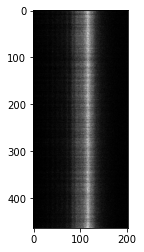

<Figure size 2880x2880 with 0 Axes>

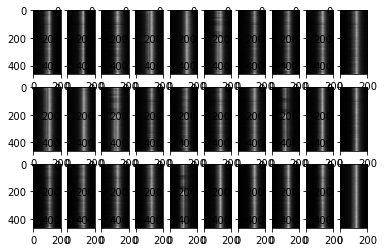

In [6]:

# plot the first sample in x as a 2D image
import matplotlib.pyplot as plt
plt.imshow(x_clean[0,:,:, 0], cmap='gray')

plt.show()

# plot the first 10 sample in x as a 2D image, 3 samples per row
# make the plot bigger
plt.figure(figsize=(40, 40))

fig, axs = plt.subplots(3, 10)
for i in range(3):
    for j in range(10):
        axs[i, j].imshow(x_clean[i*3+j,:,:, 0], cmap='gray')
plt.show()




In [7]:
# model file
model = keras.models.load_model(model_file, custom_objects={'sens': sens, 'spec': spec, 'get_f1': get_f1})
# get the 7th sample in x, but keep the first dimension
i=0
x= x_clean[i, :, :, :]
y= y_clean[i]


x = np.expand_dims(x, axis=0)


In [8]:
x.shape
y

1

In [9]:
model.predict(x)



array([[0.9947638]], dtype=float32)

In [10]:

from keract import get_activations
activations = get_activations(model, x)

input_1 (1, 464, 201, 3) 


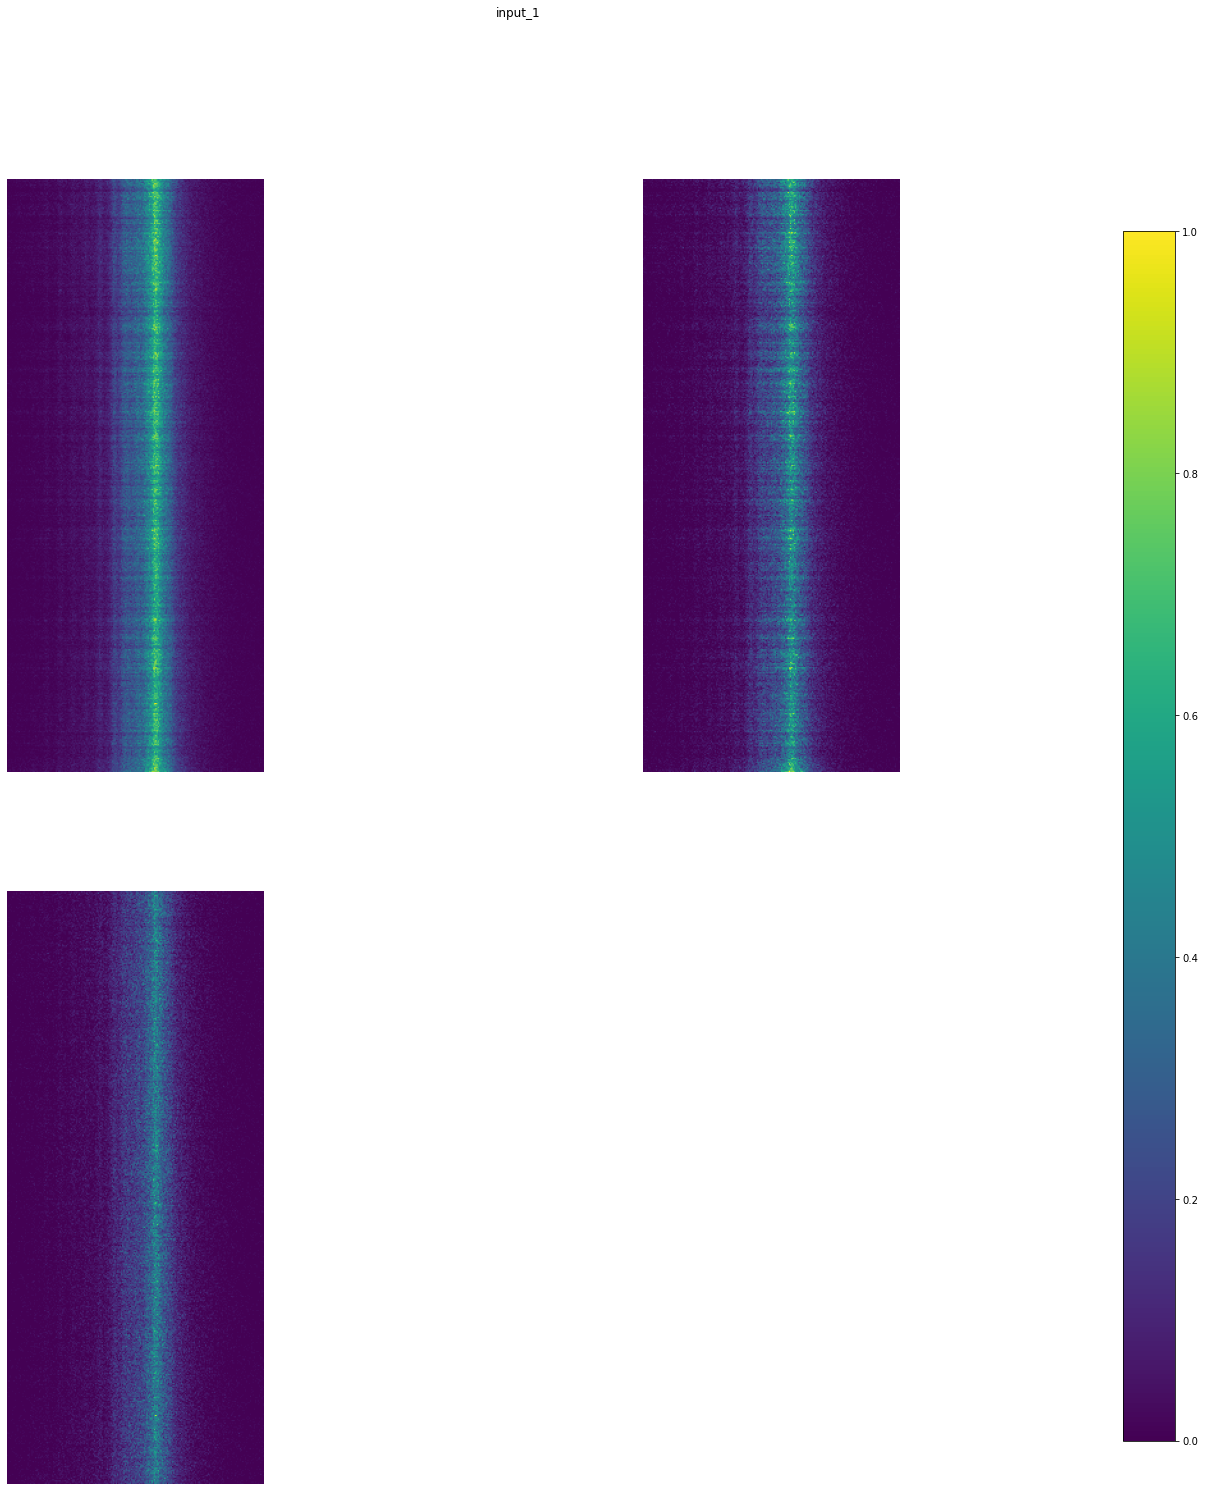

conv2d (1, 462, 199, 8) 


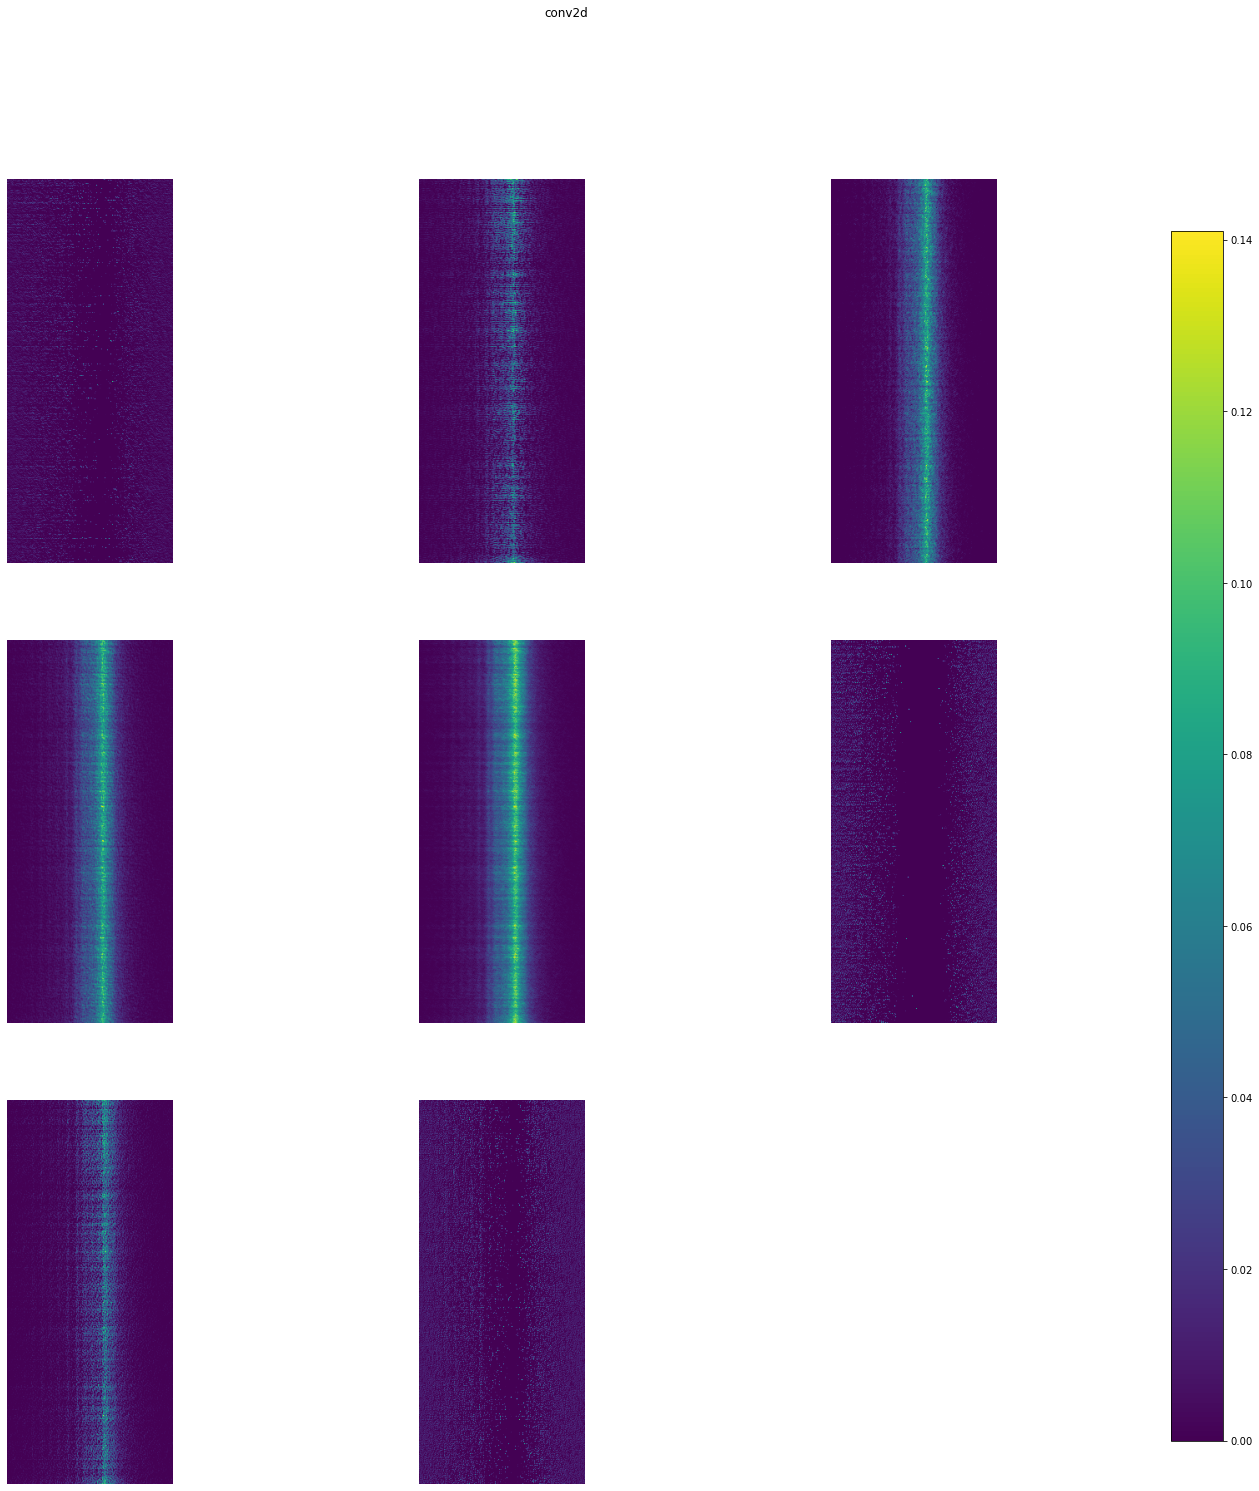

max_pooling2d (1, 154, 99, 8) 


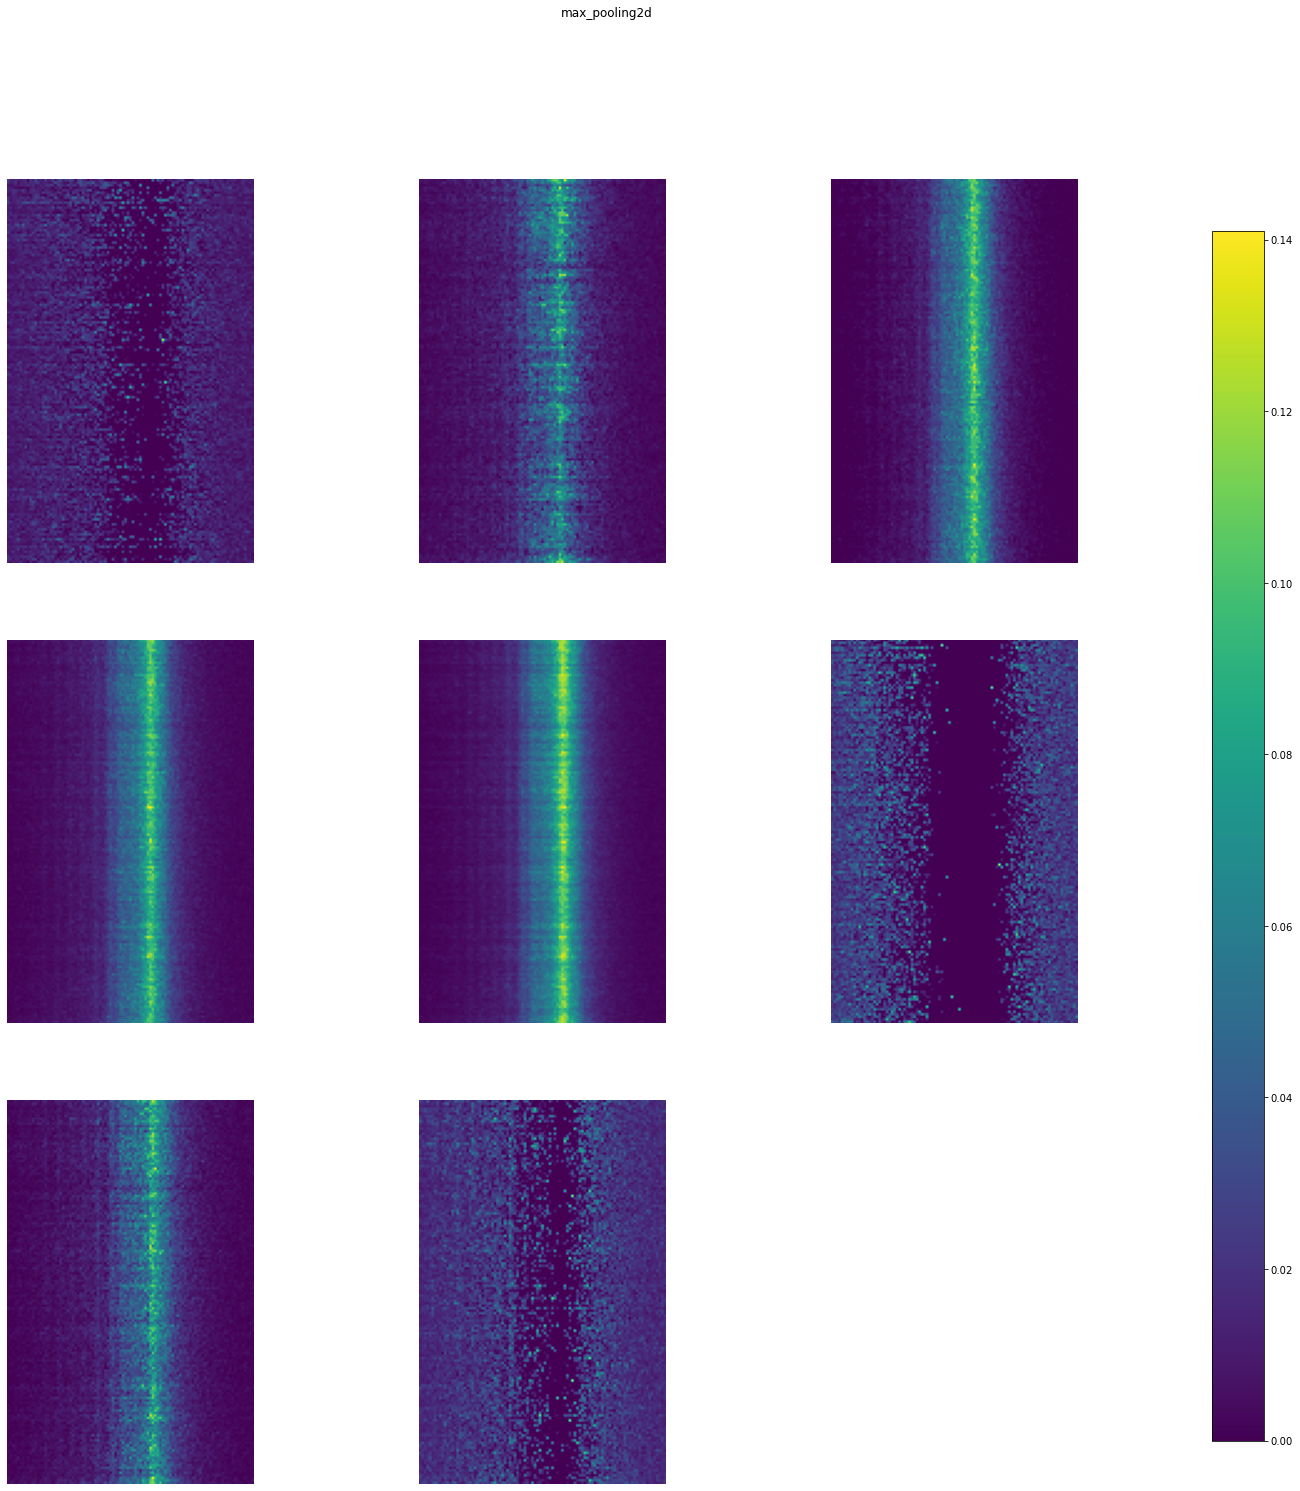

conv2d_1 (1, 152, 97, 8) 


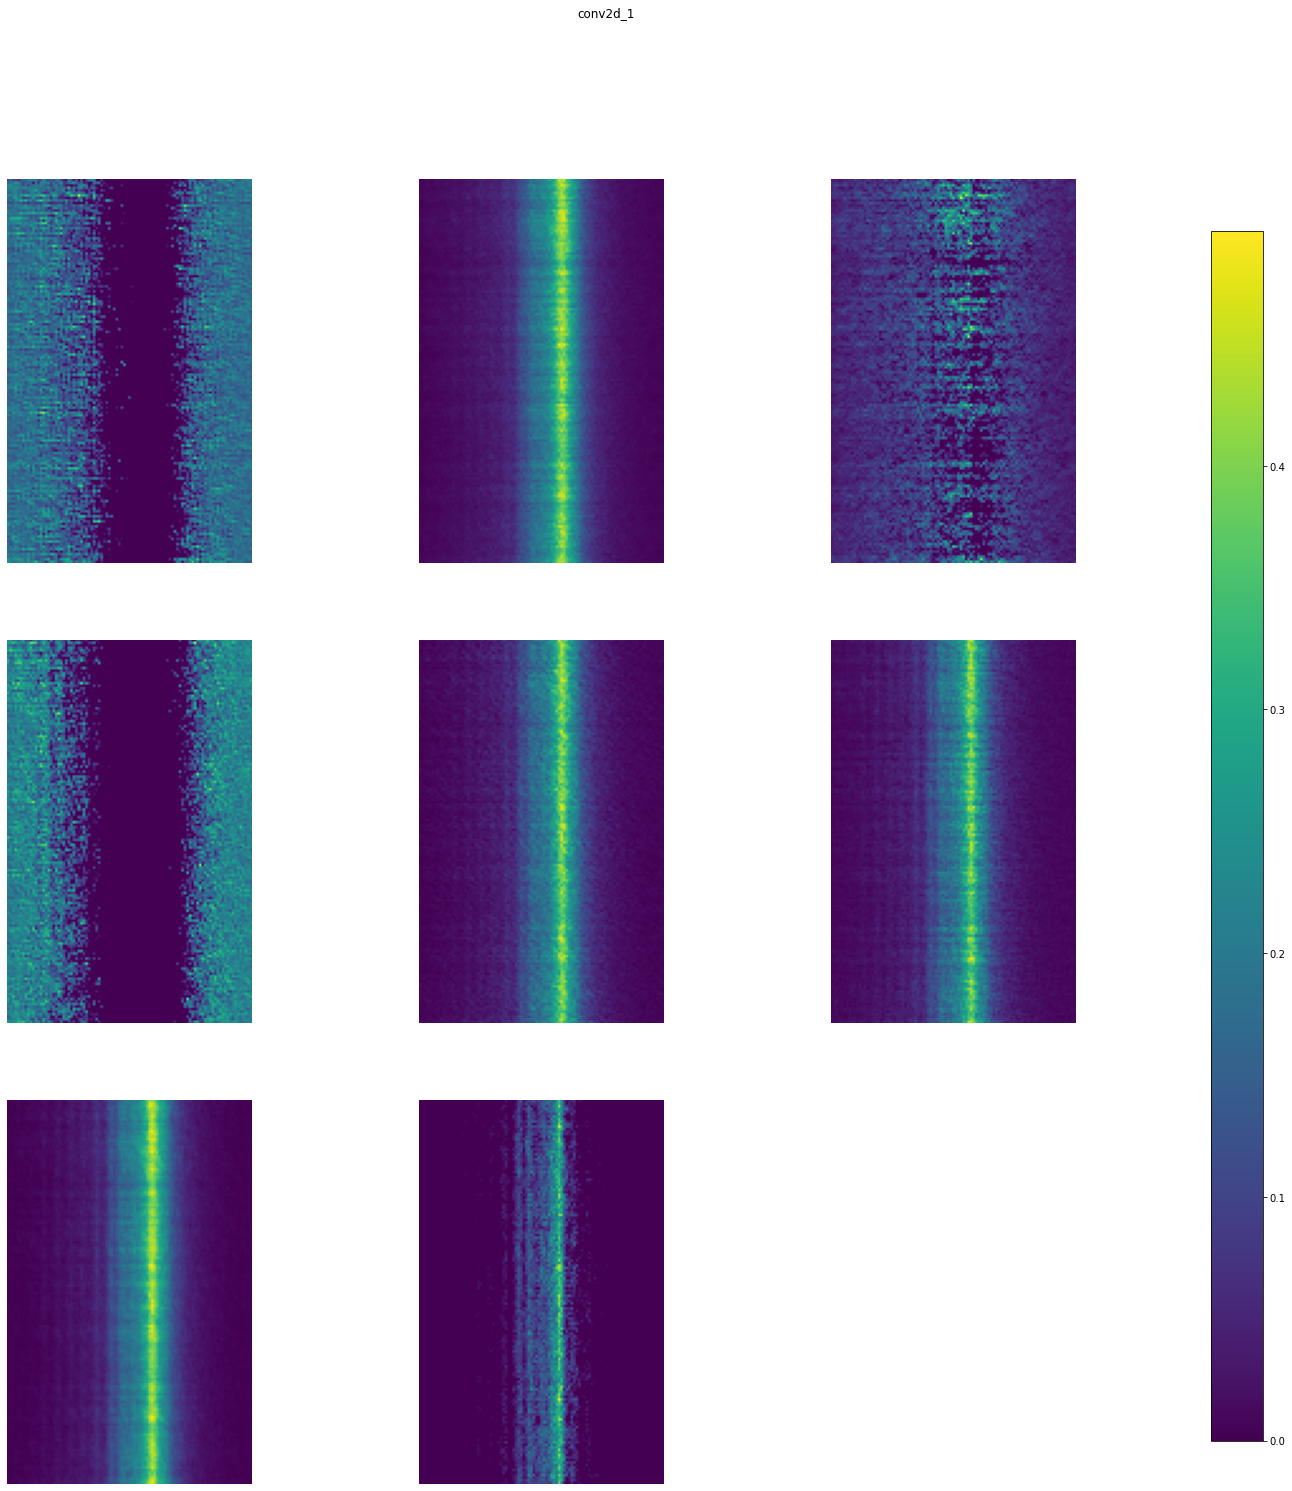

max_pooling2d_1 (1, 76, 48, 8) 


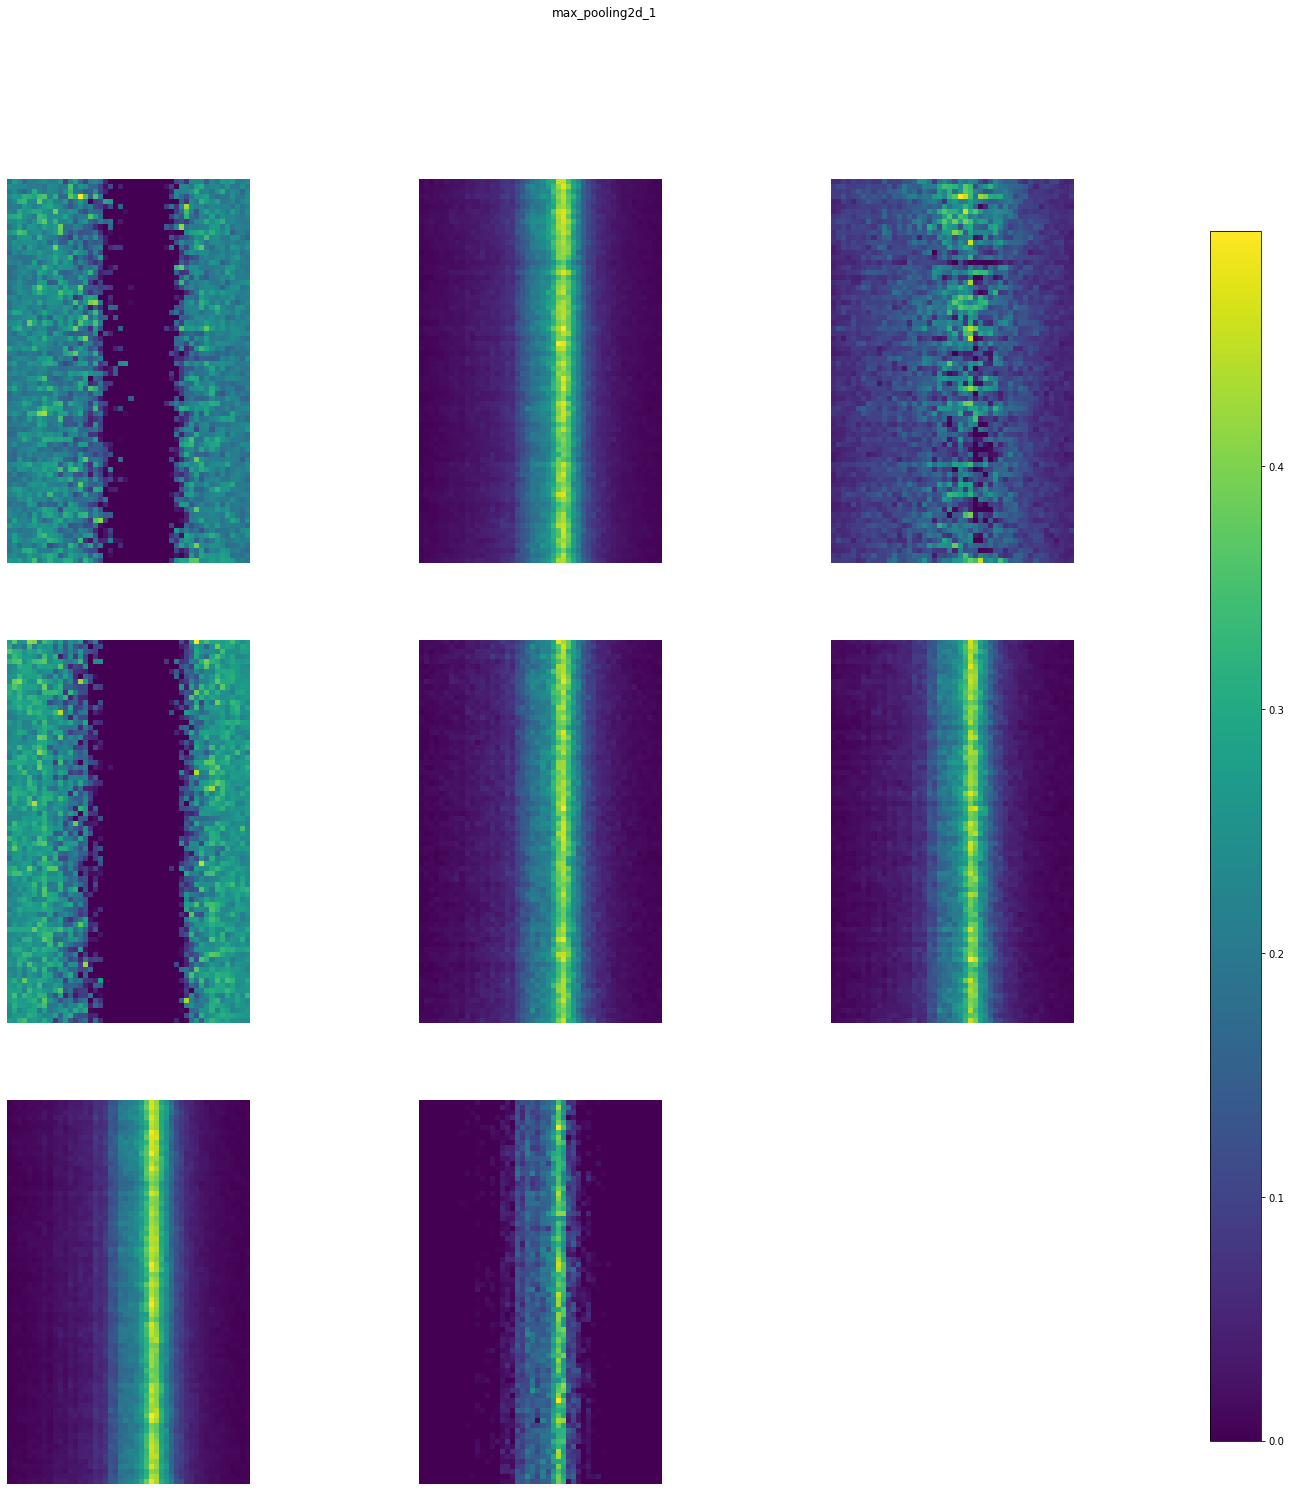

conv2d_2 (1, 74, 46, 16) 


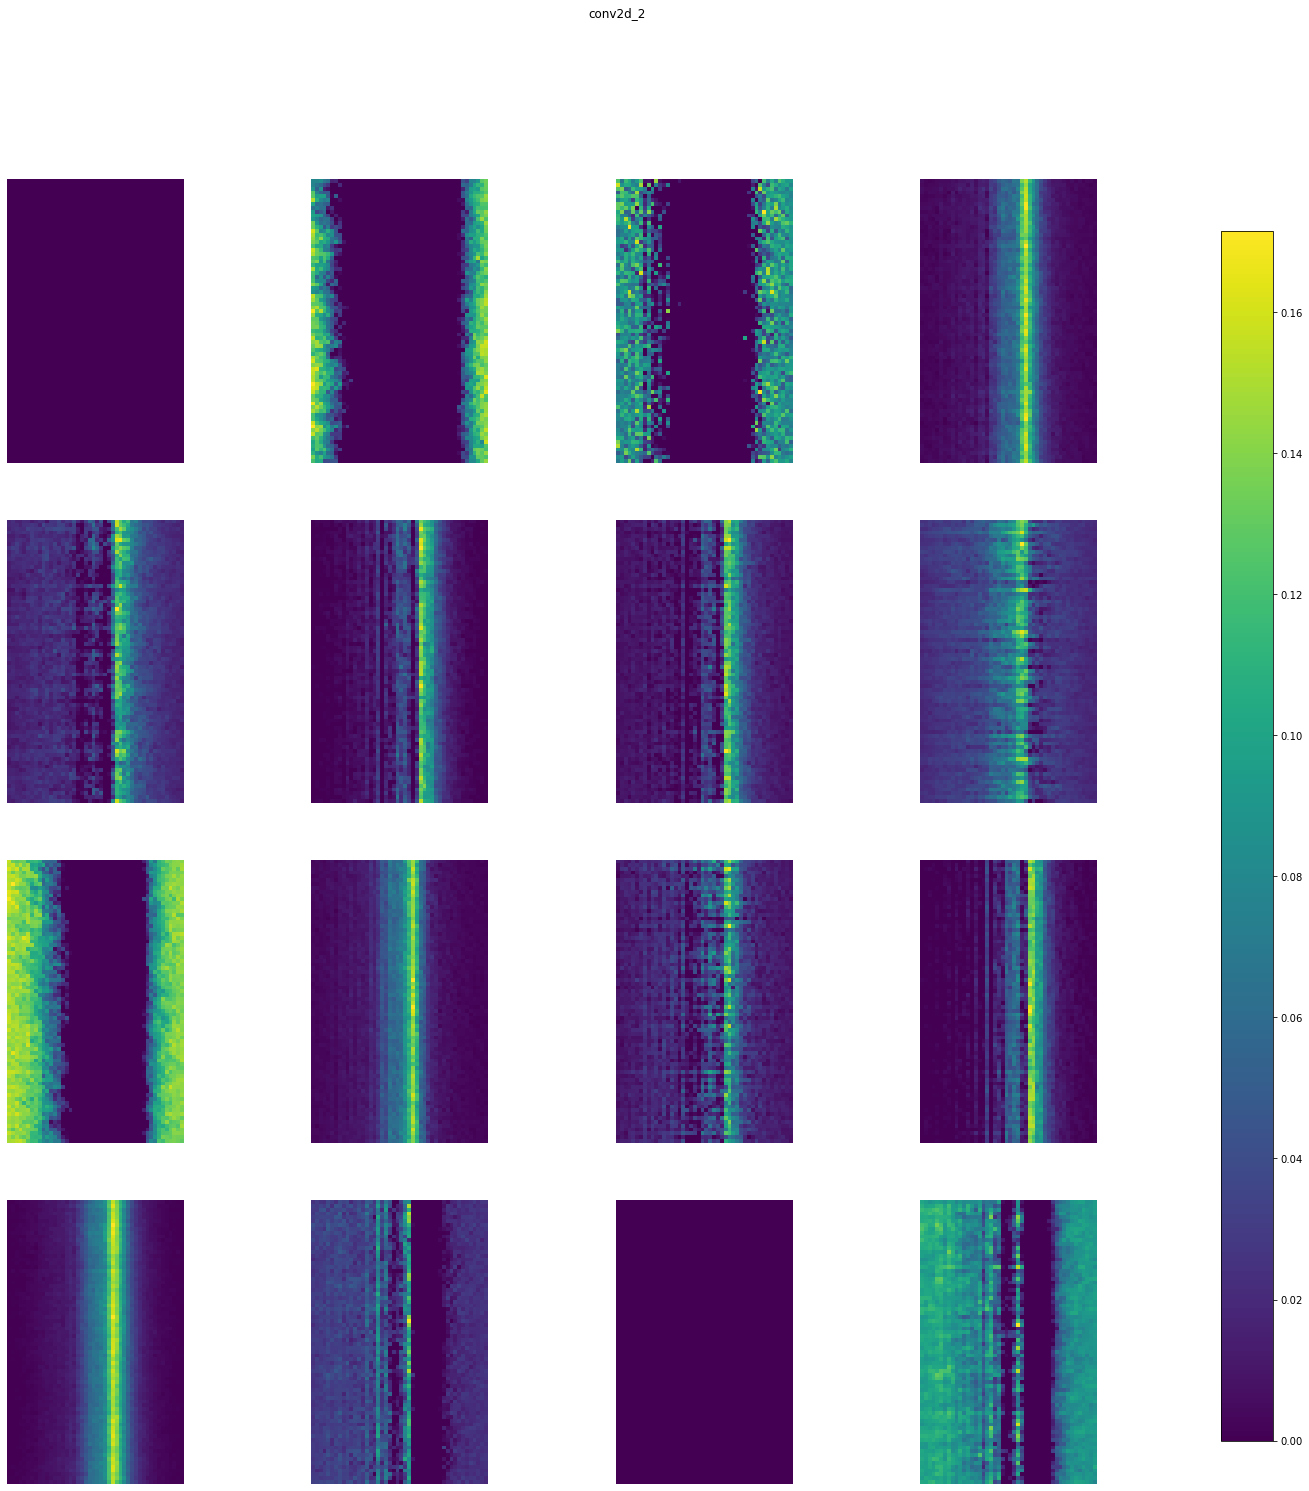

max_pooling2d_2 (1, 37, 23, 16) 


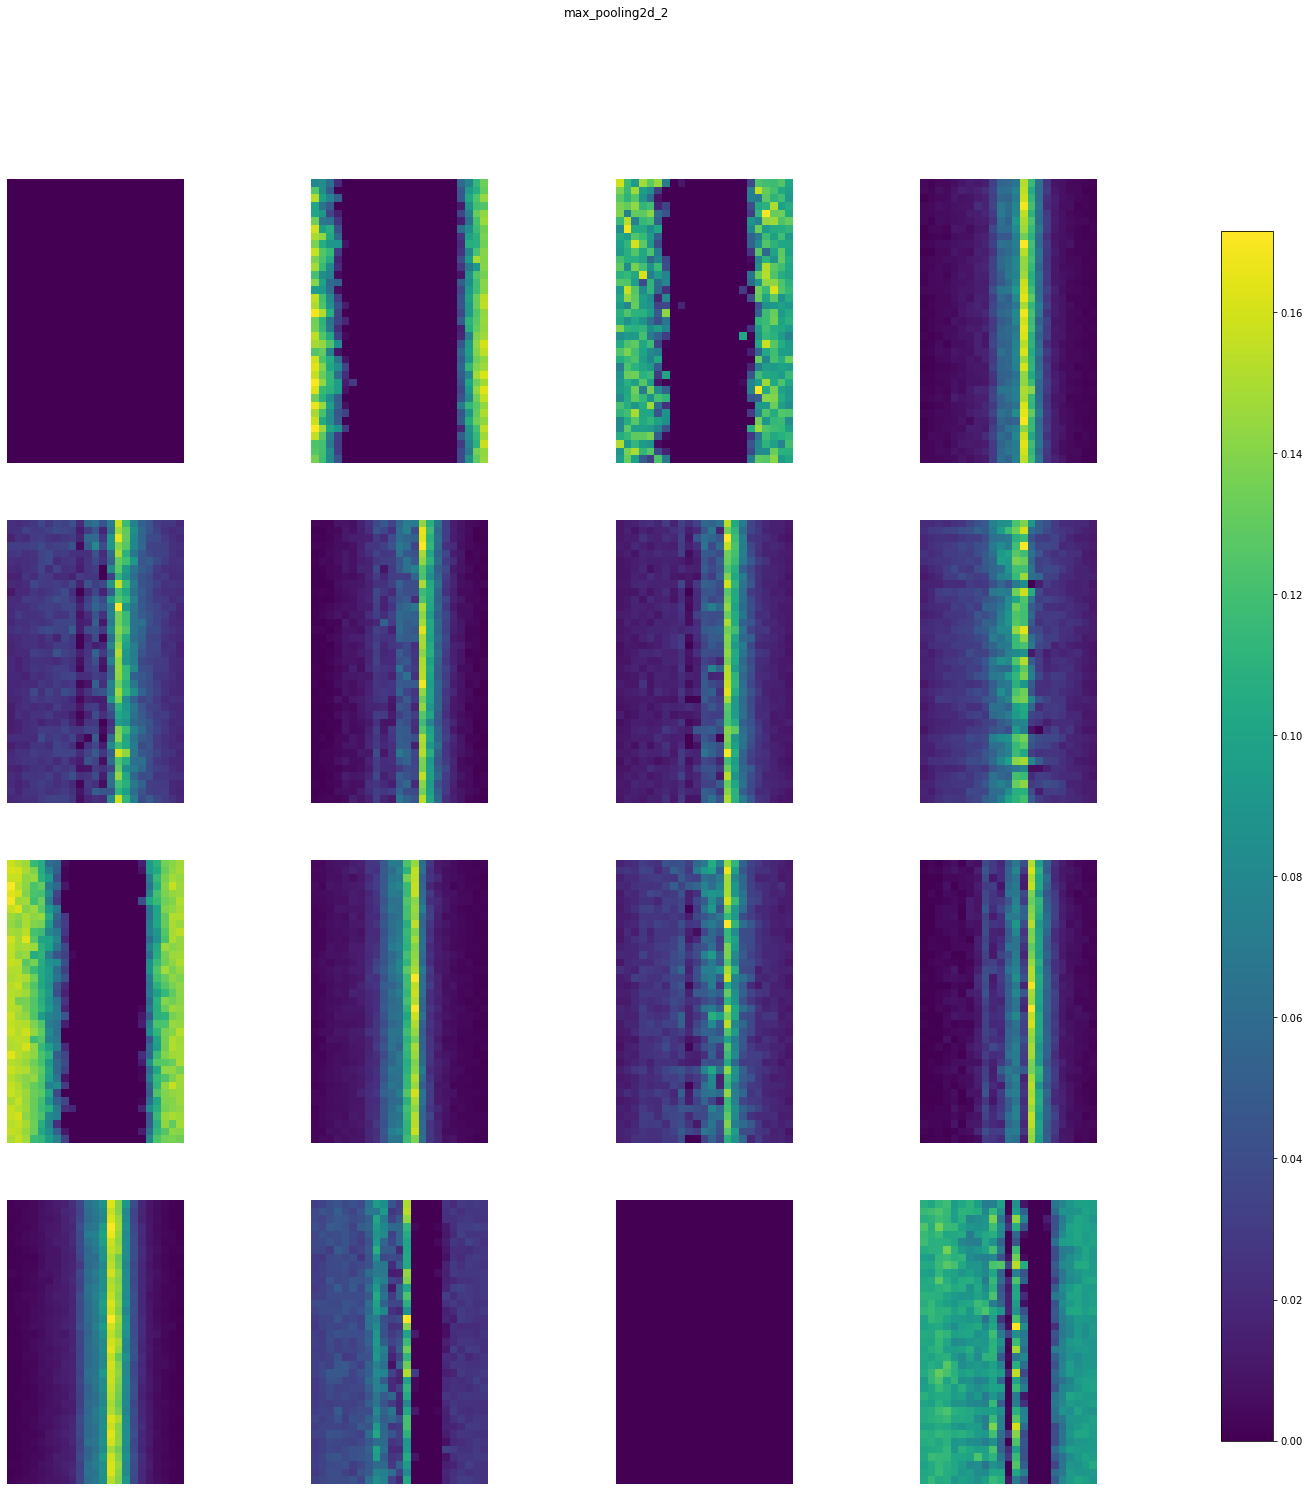

flatten (1, 13616) 


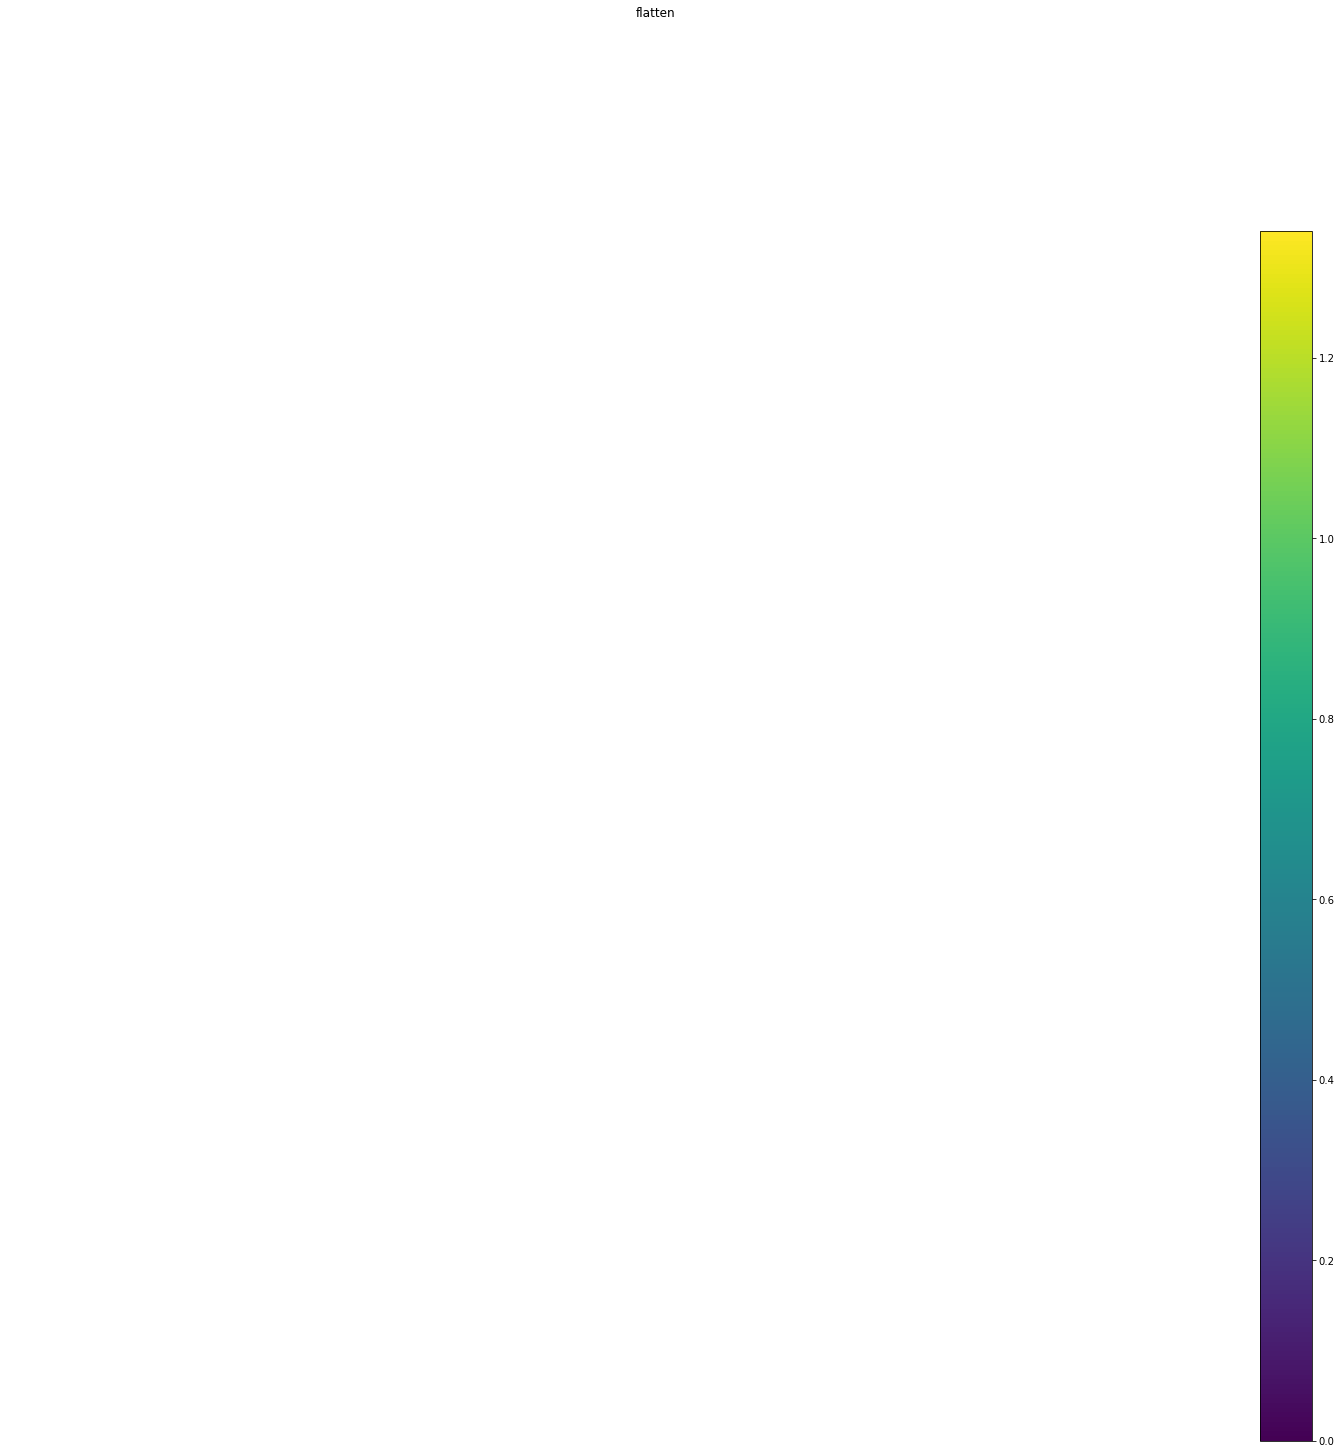

dense (1, 32) 


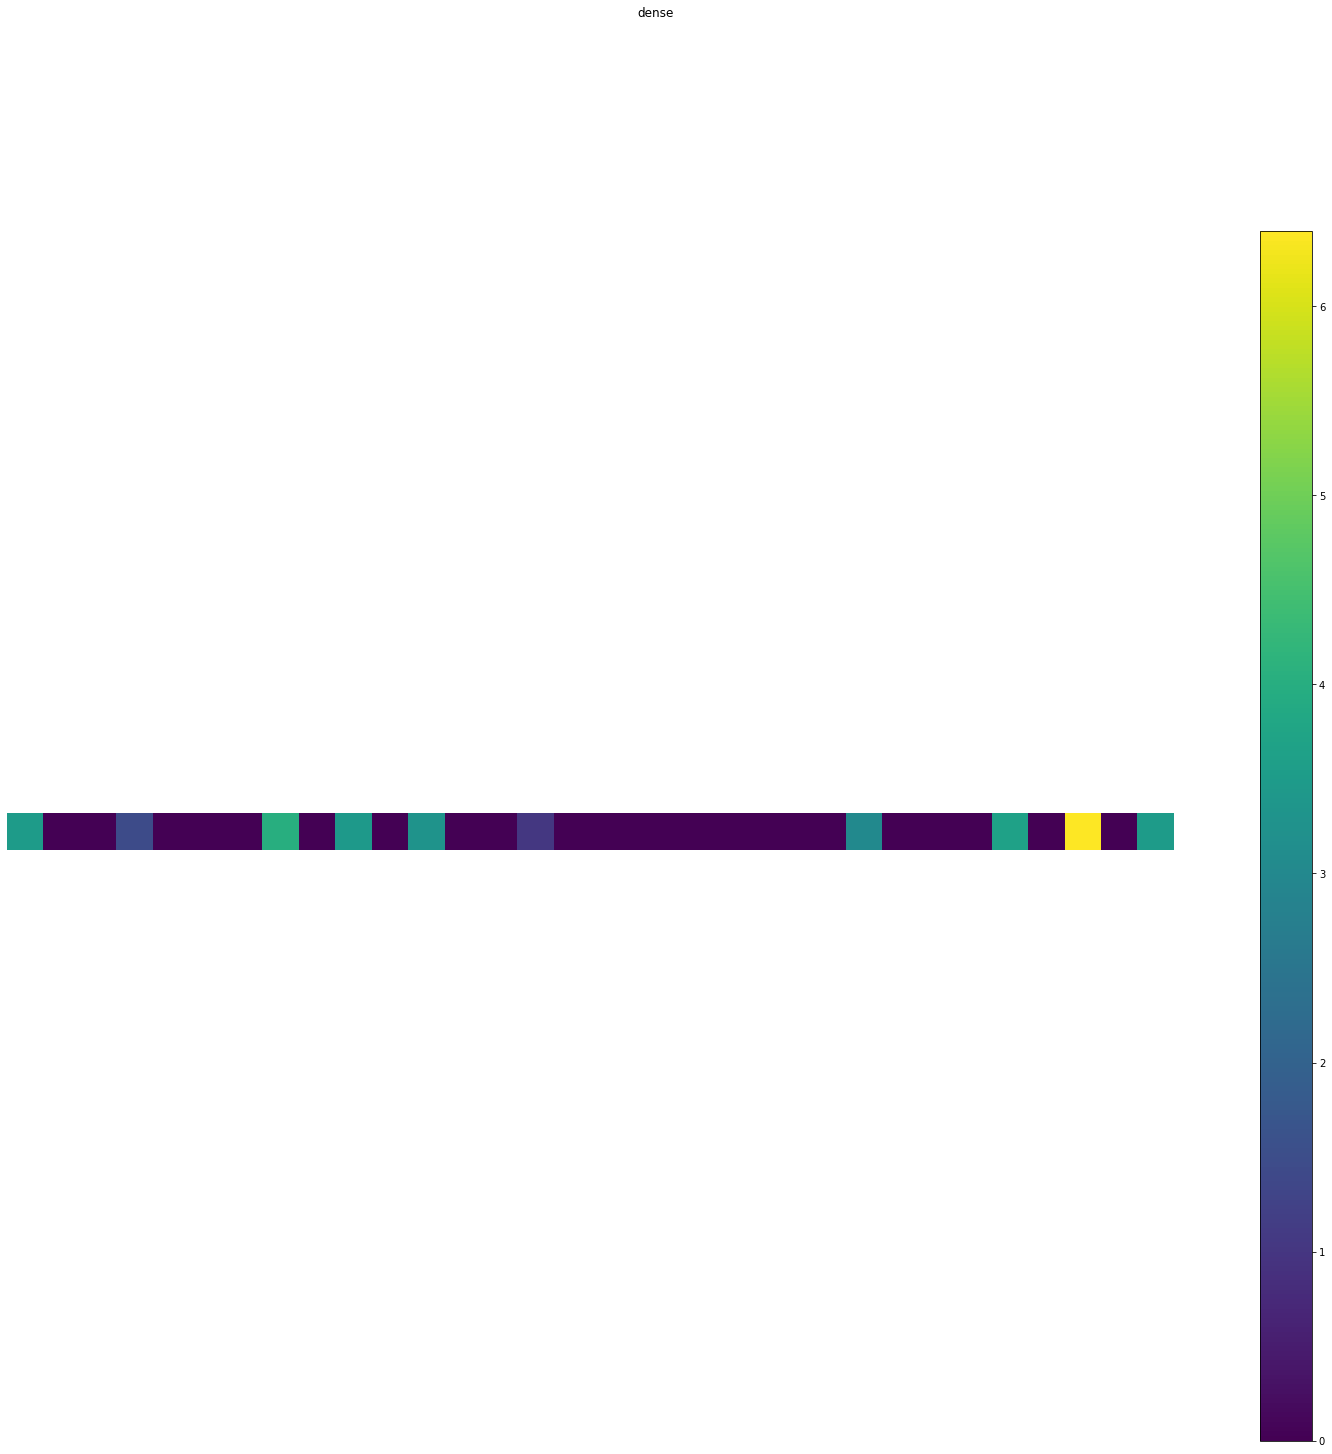

dense_1 (1, 1) 


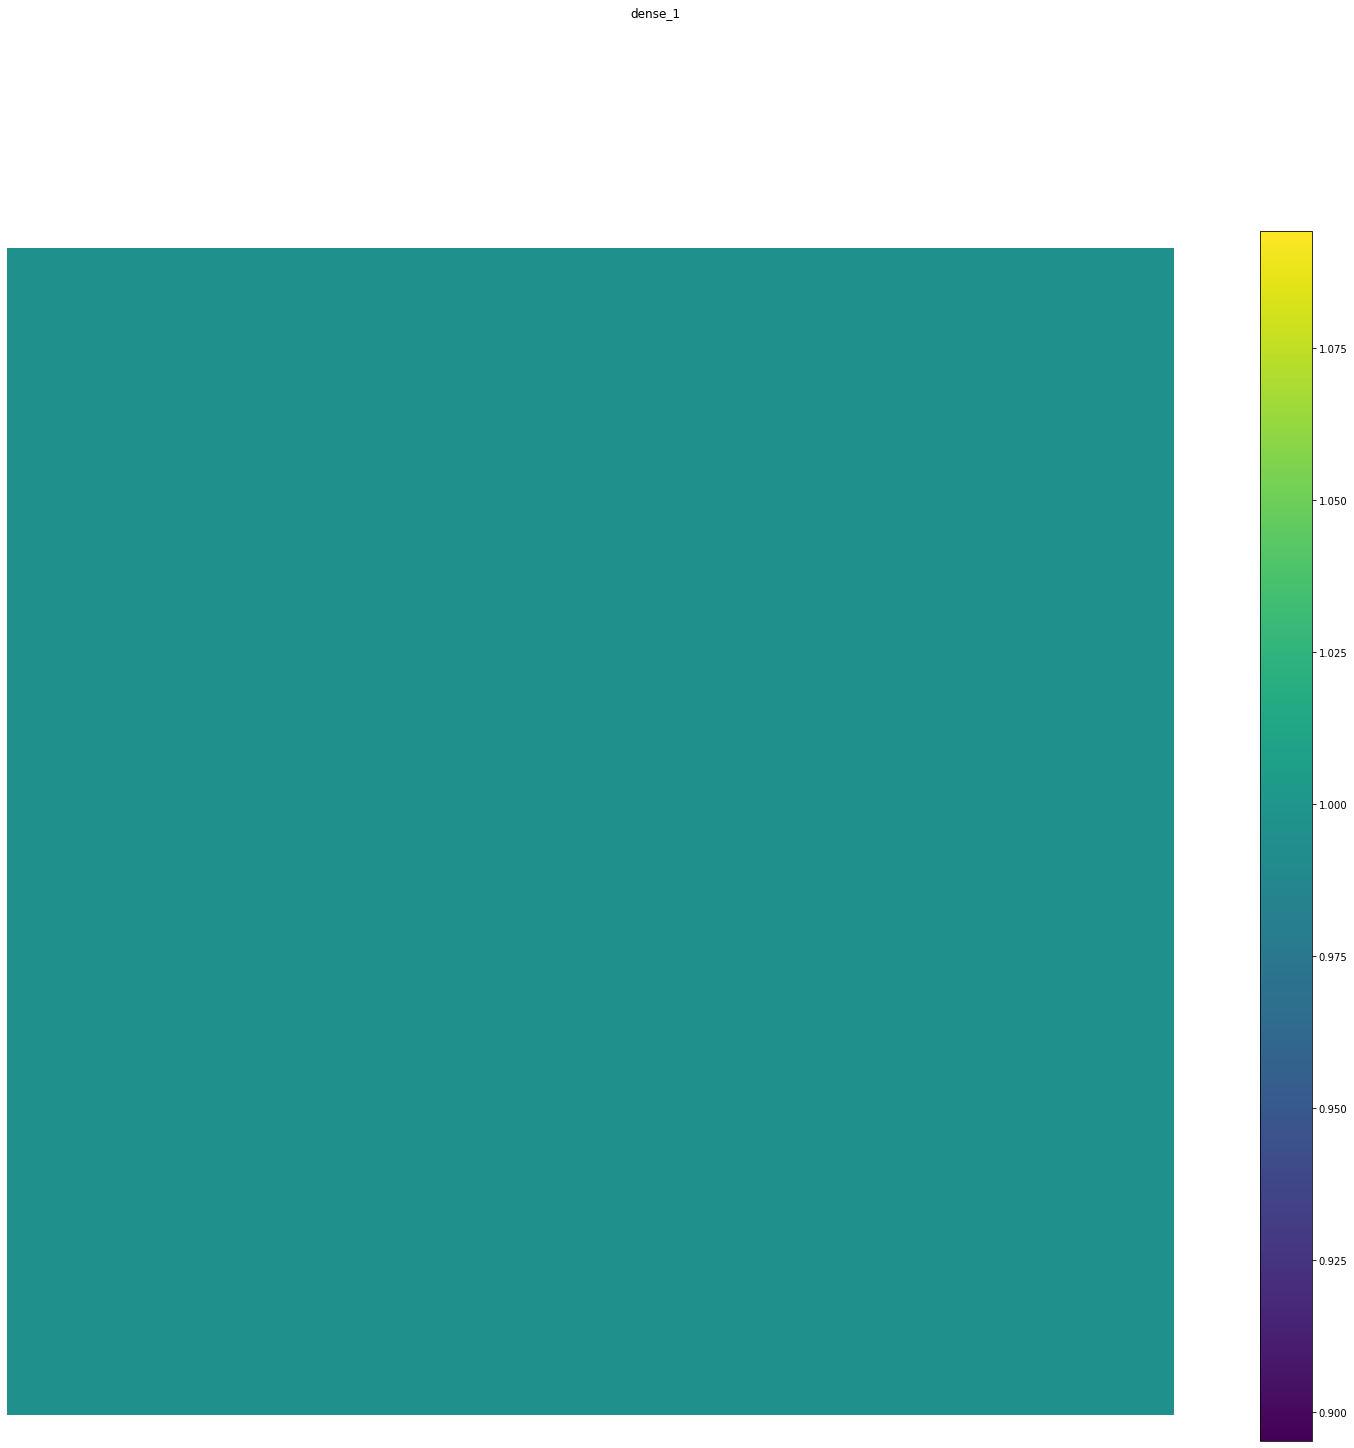

In [11]:

from keract import display_activations
display_activations(activations, save=False)

input_1 (1, 464, 201, 3) 


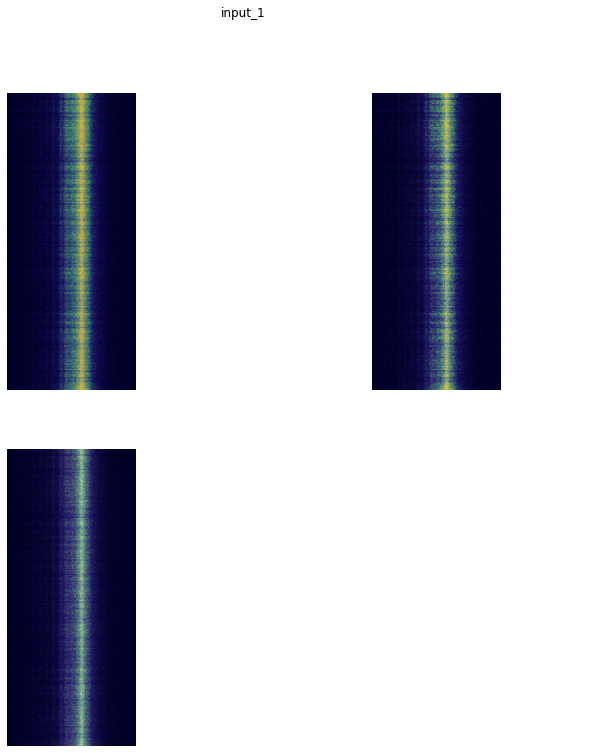

conv2d (1, 462, 199, 8) 


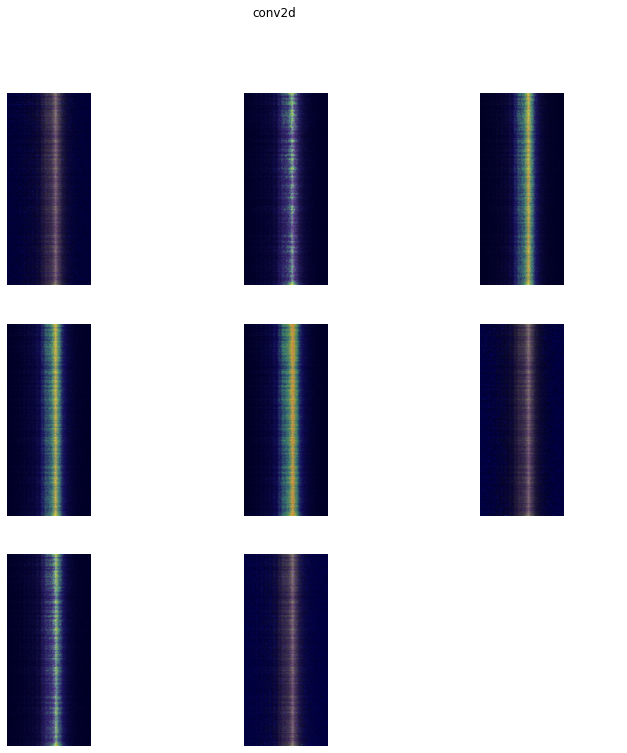

max_pooling2d (1, 154, 99, 8) 


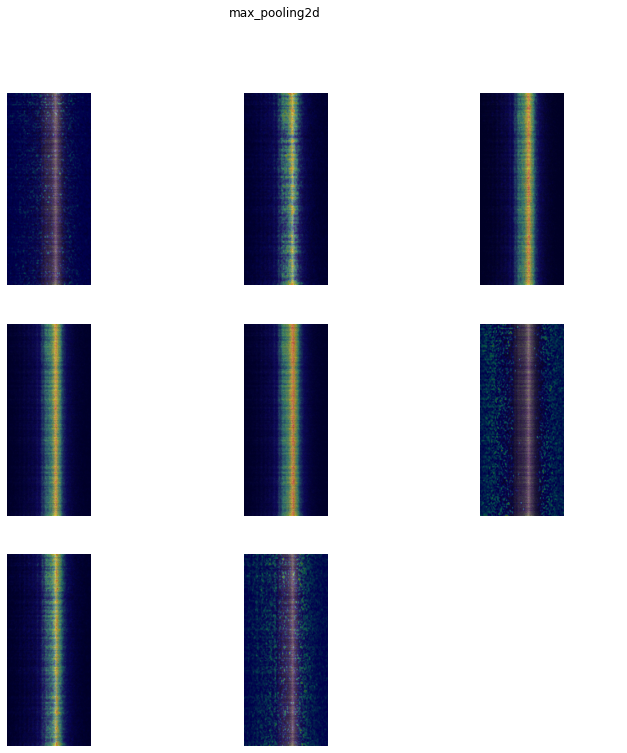

conv2d_1 (1, 152, 97, 8) 


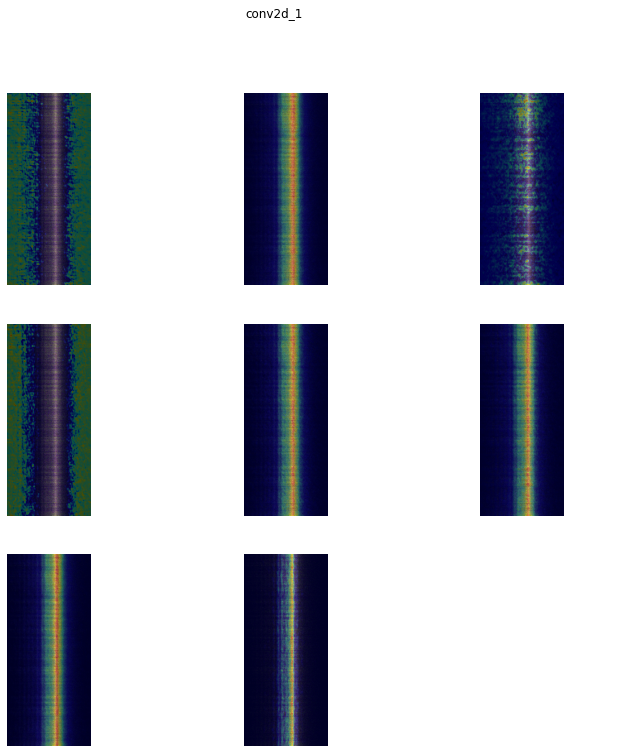

max_pooling2d_1 (1, 76, 48, 8) 


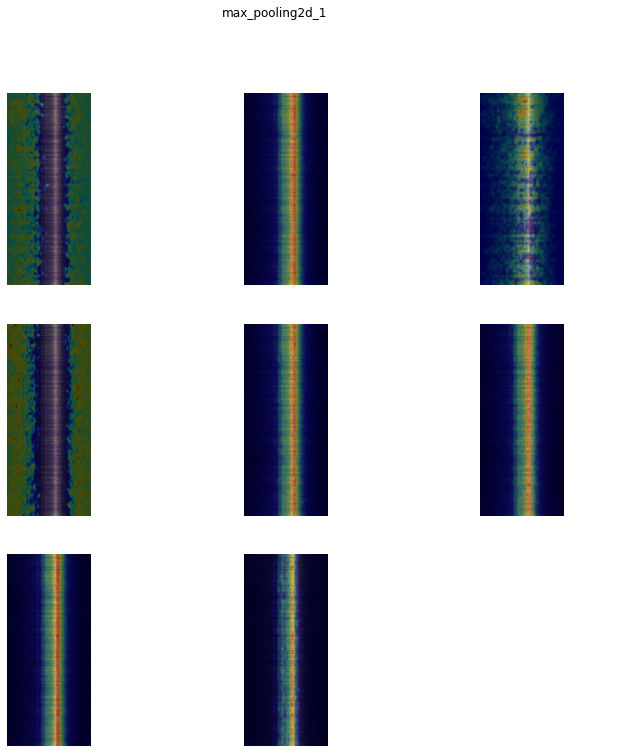

conv2d_2 (1, 74, 46, 16) 


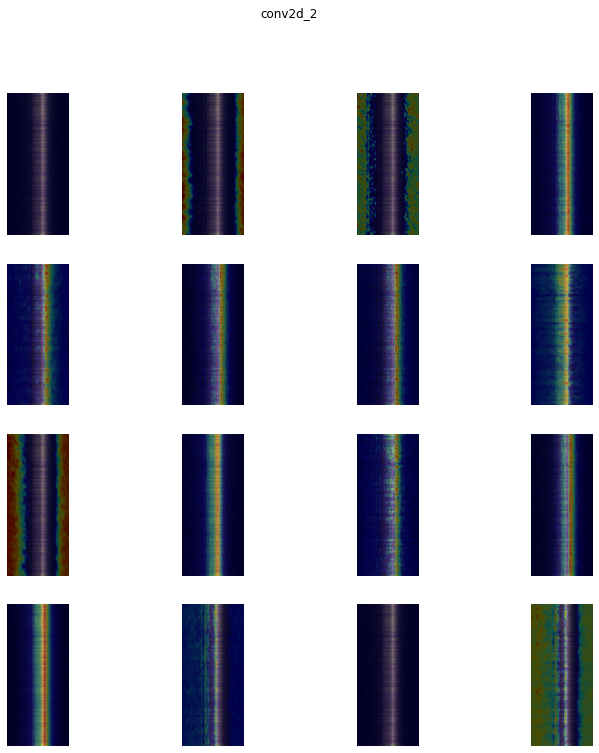

max_pooling2d_2 (1, 37, 23, 16) 


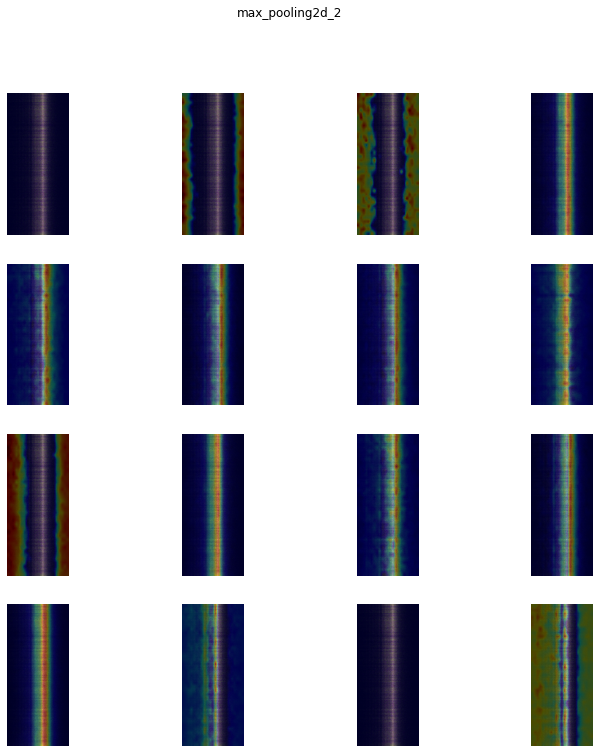

flatten (1, 13616) -> Skipped. 2D Activations.
dense (1, 32) -> Skipped. 2D Activations.
dense_1 (1, 1) -> Skipped. 2D Activations.


In [12]:

# display heatmap
from keract import display_heatmaps
display_heatmaps(activations, x, save=False)

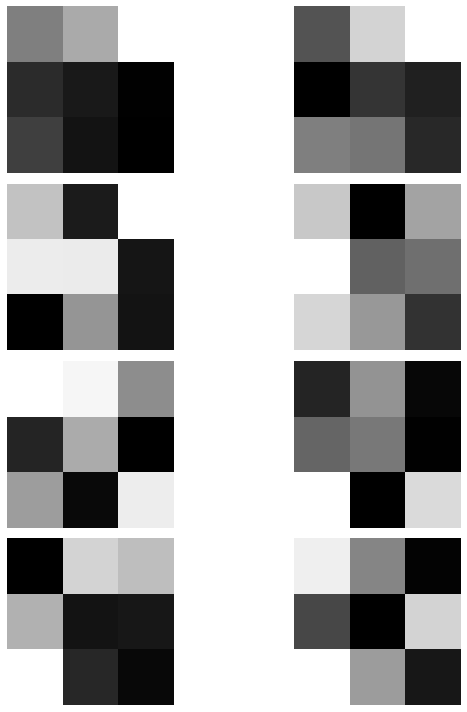

In [13]:

import matplotlib.pyplot as plt
import numpy as np

def visualize_filters(model, layer_name):
    # Extract the weights from the specified layer
    layer_weights = model.get_layer(layer_name).get_weights()[0]
    
    # Normalize the filter weights between 0 and 1 for better visualization
    layer_weights = (layer_weights - np.min(layer_weights)) / (np.max(layer_weights) - np.min(layer_weights))
    
    # Determine the number of filters and their dimensions
    num_filters = layer_weights.shape[3]
    filter_height = layer_weights.shape[0]
    filter_width = layer_weights.shape[1]
    
    # Create a grid to display the filters
    grid_cols = int(np.sqrt(num_filters))
    grid_rows = int(np.ceil(num_filters / grid_cols))
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))
    
    # Plot each filter
    filter_index = 0
    for row in range(grid_rows):
        for col in range(grid_cols):
            if filter_index < num_filters:
                # Get the filter weights for the current filter
                filter_weights = layer_weights[:, :, :, filter_index]
                
                # Plot the filter weights as an image
                axes[row, col].imshow(filter_weights[:,:,0], cmap='gray')
                axes[row, col].axis('off')
                
                filter_index += 1
            else:
                # If all filters have been plotted, remove the unused subplot
                fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_filters(model, 'conv2d')


In [14]:
layer_name = 'conv2d'
layer_weights = model.get_layer(layer_name).get_weights()[0]

layer_weights.shape

(3, 3, 3, 8)